# lgbm-stacking 데모
* 알고리즘 rf, lgbm, lr 적용한 앙상블 기법  stacking 적용
* 개별 모델이 예측한 데이터를 다시 training set 으로 사용해서 학습  

## 라이브러리 import 및 설정

In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)       #그림 사이즈 지정
plt.style.use('fivethirtyeight')           #그림 기본 스타일
pd.set_option('max_columns', 100)          #칼럼 100개 허용
pd.set_option("display.precision", 4)      #소수점 4자리허용
warnings.simplefilter('ignore')            #경고분 무시

## 학습데이터 로드

In [22]:
feature_file = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\feature.csv'
sample_file  = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\sample_submission.csv'
tst_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\testset.csv'
trn_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\trainset.csv'
val_dir      = Path('C:\\Users\\USER\\Desktop\\Dataset\\val')
tst_dir      = Path('C:\\Users\\USER\\Desktop\\Dataset\\tst')

## Stacking Feature 생성

In [23]:
model_names = ['lrcvPolyfeature', 'rfcvFeature', 'lgbmcvFeature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(pd.read_csv(val_dir / f'{model}.val.csv', delimiter=',',header=None))
    tst.append(pd.read_csv(tst_dir / f'{model}.tst.csv', delimiter=',',header=None))
    feature_names += [f'{model}_0CO', f'{model}_1EL', f'{model}_2GR', f'{model}_3HI', f'{model}_4MI', f'{model}_5PH']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcvPolyfeature_0CO',
 'lrcvPolyfeature_1EL',
 'lrcvPolyfeature_2GR',
 'lrcvPolyfeature_3HI',
 'lrcvPolyfeature_4MI',
 'lrcvPolyfeature_5PH',
 'rfcvFeature_0CO',
 'rfcvFeature_1EL',
 'rfcvFeature_2GR',
 'rfcvFeature_3HI',
 'rfcvFeature_4MI',
 'rfcvFeature_5PH',
 'lgbmcvFeature_0CO',
 'lgbmcvFeature_1EL',
 'lgbmcvFeature_2GR',
 'lgbmcvFeature_3HI',
 'lgbmcvFeature_4MI',
 'lgbmcvFeature_5PH']

In [24]:
df = pd.read_csv(trn_file, header=None)
y = pd.DataFrame(df[0].values.flatten())
y.shape

(4280, 1)

In [25]:
seed=150
kfold=10

## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [26]:
cv = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=seed)

### [범주형 > 수치형 변환_종속변수]

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

label_str=y
label_int=le.fit_transform(label_str).astype('int')
y
label_int

array([3, 5, 2, ..., 1, 5, 1])

## LightGBM 모델 학습

In [28]:
p_val = np.zeros((trn.shape[0], 6))
p_tst = np.zeros((tst.shape[0], 6))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             #boosting_type='dart', 
                             #n_estimators=300,
                             #learning_rate=0.1,
                             #num_leaves=64,
                            # min_child_samples=10,   
                            # subsample=.5,                       
                            # subsample_freq=1,    
                             #colsample_bytree= 0.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], label_int[i_trn],
            eval_set=[(trn[i_val], label_int[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=15)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / kfold
print(f'{accuracy_score(label_int, np.argmax(p_val, axis=1)) * 100:.4f}%')

training model for CV #1
[1]	valid_0's multi_logloss: 1.33176
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.09859
[3]	valid_0's multi_logloss: 0.930877
[4]	valid_0's multi_logloss: 0.805459
[5]	valid_0's multi_logloss: 0.704994
[6]	valid_0's multi_logloss: 0.626196
[7]	valid_0's multi_logloss: 0.561101
[8]	valid_0's multi_logloss: 0.507383
[9]	valid_0's multi_logloss: 0.464569
[10]	valid_0's multi_logloss: 0.426836
[11]	valid_0's multi_logloss: 0.398122
[12]	valid_0's multi_logloss: 0.370911
[13]	valid_0's multi_logloss: 0.351142
[14]	valid_0's multi_logloss: 0.334921
[15]	valid_0's multi_logloss: 0.320919
[16]	valid_0's multi_logloss: 0.309336
[17]	valid_0's multi_logloss: 0.29834
[18]	valid_0's multi_logloss: 0.288933
[19]	valid_0's multi_logloss: 0.282313
[20]	valid_0's multi_logloss: 0.277816
[21]	valid_0's multi_logloss: 0.272058
[22]	valid_0's multi_logloss: 0.267682
[23]	valid_0's multi_logloss: 0.26463
[24]	valid_0's multi_logloss: 

[31]	valid_0's multi_logloss: 0.272668
[32]	valid_0's multi_logloss: 0.274848
[33]	valid_0's multi_logloss: 0.277076
[34]	valid_0's multi_logloss: 0.278514
[35]	valid_0's multi_logloss: 0.279191
[36]	valid_0's multi_logloss: 0.281654
[37]	valid_0's multi_logloss: 0.283638
[38]	valid_0's multi_logloss: 0.286894
[39]	valid_0's multi_logloss: 0.287896
[40]	valid_0's multi_logloss: 0.291353
[41]	valid_0's multi_logloss: 0.293788
[42]	valid_0's multi_logloss: 0.294187
[43]	valid_0's multi_logloss: 0.296437
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.270614
training model for CV #6
[1]	valid_0's multi_logloss: 1.32713
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.09057
[3]	valid_0's multi_logloss: 0.923697
[4]	valid_0's multi_logloss: 0.796639
[5]	valid_0's multi_logloss: 0.696747
[6]	valid_0's multi_logloss: 0.618441
[7]	valid_0's multi_logloss: 0.552711
[8]	valid_0's multi_logloss: 0.50042
[9]	valid_0's multi_logloss: 0.4

training model for CV #10
[1]	valid_0's multi_logloss: 1.34051
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.11285
[3]	valid_0's multi_logloss: 0.949788
[4]	valid_0's multi_logloss: 0.827714
[5]	valid_0's multi_logloss: 0.731009
[6]	valid_0's multi_logloss: 0.654414
[7]	valid_0's multi_logloss: 0.589734
[8]	valid_0's multi_logloss: 0.537784
[9]	valid_0's multi_logloss: 0.494744
[10]	valid_0's multi_logloss: 0.459934
[11]	valid_0's multi_logloss: 0.430927
[12]	valid_0's multi_logloss: 0.407607
[13]	valid_0's multi_logloss: 0.388382
[14]	valid_0's multi_logloss: 0.372899
[15]	valid_0's multi_logloss: 0.358833
[16]	valid_0's multi_logloss: 0.349188
[17]	valid_0's multi_logloss: 0.341267
[18]	valid_0's multi_logloss: 0.334657
[19]	valid_0's multi_logloss: 0.330394
[20]	valid_0's multi_logloss: 0.327041
[21]	valid_0's multi_logloss: 0.325287
[22]	valid_0's multi_logloss: 0.321304
[23]	valid_0's multi_logloss: 0.319163
[24]	valid_0's multi_loglos

In [29]:
scores = cross_val_score(clf, trn,y, cv=10) # model, train, target, cross validation
print('cross-val-score.mean \n{:.4f}%'.format(scores.mean()*100))

cross-val-score.mean 
91.2850%


In [31]:
#3000 256 003 10 08 06 42 15번  >>90
p_val = np.zeros((trn.shape[0], 6))
p_tst = np.zeros((tst.shape[0], 6))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=42,
                             n_jobs=-1)
    clf.fit(trn[i_trn], label_int[i_trn],
            eval_set=[(trn[i_val], label_int[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=15)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / kfold

training model for CV #1
[1]	valid_0's multi_logloss: 1.3341
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.10426
[3]	valid_0's multi_logloss: 0.934106
[4]	valid_0's multi_logloss: 0.809816
[5]	valid_0's multi_logloss: 0.712545
[6]	valid_0's multi_logloss: 0.633755
[7]	valid_0's multi_logloss: 0.571505
[8]	valid_0's multi_logloss: 0.51755
[9]	valid_0's multi_logloss: 0.476104
[10]	valid_0's multi_logloss: 0.441274
[11]	valid_0's multi_logloss: 0.407754
[12]	valid_0's multi_logloss: 0.383484
[13]	valid_0's multi_logloss: 0.361799
[14]	valid_0's multi_logloss: 0.345926
[15]	valid_0's multi_logloss: 0.33098
[16]	valid_0's multi_logloss: 0.318071
[17]	valid_0's multi_logloss: 0.304949
[18]	valid_0's multi_logloss: 0.297817
[19]	valid_0's multi_logloss: 0.291833
[20]	valid_0's multi_logloss: 0.285674
[21]	valid_0's multi_logloss: 0.282317
[22]	valid_0's multi_logloss: 0.280365
[23]	valid_0's multi_logloss: 0.278853
[24]	valid_0's multi_logloss: 0

[16]	valid_0's multi_logloss: 0.319675
[17]	valid_0's multi_logloss: 0.309727
[18]	valid_0's multi_logloss: 0.30098
[19]	valid_0's multi_logloss: 0.295542
[20]	valid_0's multi_logloss: 0.289911
[21]	valid_0's multi_logloss: 0.285989
[22]	valid_0's multi_logloss: 0.28275
[23]	valid_0's multi_logloss: 0.280516
[24]	valid_0's multi_logloss: 0.278236
[25]	valid_0's multi_logloss: 0.278732
[26]	valid_0's multi_logloss: 0.275563
[27]	valid_0's multi_logloss: 0.275283
[28]	valid_0's multi_logloss: 0.277227
[29]	valid_0's multi_logloss: 0.27825
[30]	valid_0's multi_logloss: 0.278791
[31]	valid_0's multi_logloss: 0.27811
[32]	valid_0's multi_logloss: 0.282011
[33]	valid_0's multi_logloss: 0.283128
[34]	valid_0's multi_logloss: 0.284858
[35]	valid_0's multi_logloss: 0.285661
[36]	valid_0's multi_logloss: 0.287742
[37]	valid_0's multi_logloss: 0.288977
[38]	valid_0's multi_logloss: 0.290659
[39]	valid_0's multi_logloss: 0.291762
[40]	valid_0's multi_logloss: 0.292242
[41]	valid_0's multi_logloss:

[40]	valid_0's multi_logloss: 0.24501
[41]	valid_0's multi_logloss: 0.247719
[42]	valid_0's multi_logloss: 0.247686
[43]	valid_0's multi_logloss: 0.248494
[44]	valid_0's multi_logloss: 0.252017
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.238119
training model for CV #10
[1]	valid_0's multi_logloss: 1.34323
Training until validation scores don't improve for 15 rounds
[2]	valid_0's multi_logloss: 1.11906
[3]	valid_0's multi_logloss: 0.95378
[4]	valid_0's multi_logloss: 0.830195
[5]	valid_0's multi_logloss: 0.728339
[6]	valid_0's multi_logloss: 0.652512
[7]	valid_0's multi_logloss: 0.589832
[8]	valid_0's multi_logloss: 0.535206
[9]	valid_0's multi_logloss: 0.491318
[10]	valid_0's multi_logloss: 0.4603
[11]	valid_0's multi_logloss: 0.43509
[12]	valid_0's multi_logloss: 0.412125
[13]	valid_0's multi_logloss: 0.393533
[14]	valid_0's multi_logloss: 0.374962
[15]	valid_0's multi_logloss: 0.3613
[16]	valid_0's multi_logloss: 0.350912
[17]	valid_0's multi_logloss: 0.345577

In [32]:
print(f'{accuracy_score(label_int, np.argmax(p_val, axis=1)) * 100:.4f}%') #90.9112 강사 베이스 91.4486

91.1682%


## Simple way Cross Validation

In [33]:
scores = cross_val_score(clf, trn,y, cv=10) # model, train, target, cross validation
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()*100))

cross-val-score 
[0.9228972  0.93224299 0.9135514  0.9135514  0.91121495 0.91121495
 0.88317757 0.9228972  0.9228972  0.90186916]
cross-val-score.mean 
91.355


In [34]:
print(p_val.shape, p_tst.shape)

(4280, 6) (1833, 6)


#### [stacking 사용을 위해 p_val,p_tst 저장]

In [35]:
val_dir = Path('C:\\Users\\USER\\Desktop\\Dataset\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\Dataset\\tst')
name = 'lgbmStacking1'
model_name = f'{name}'
p_val_file = val_dir / f'{name}.val.csv'
p_tst_file = tst_dir / f'{name}.tst.csv'

In [36]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화
여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

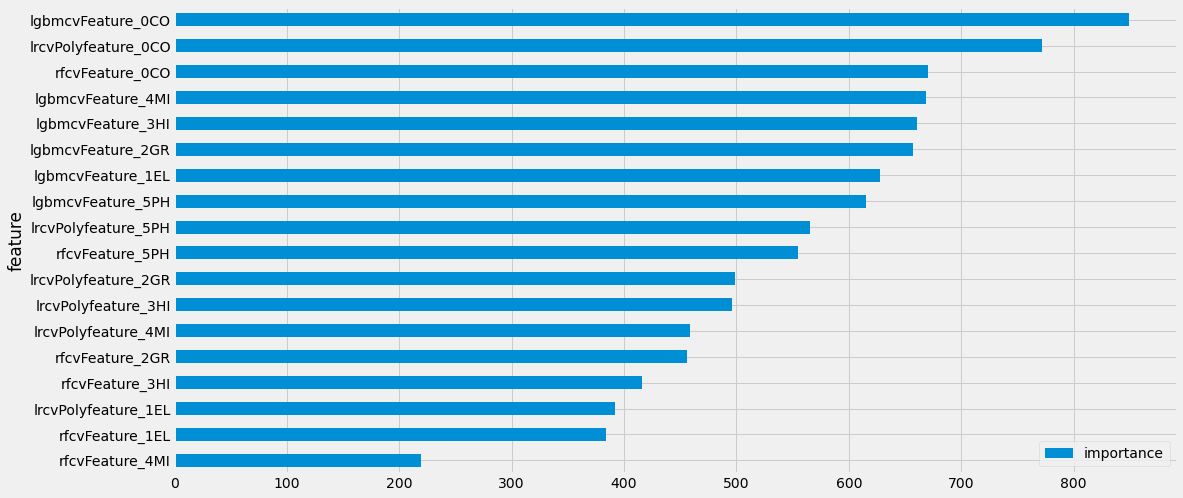

In [37]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### [수치형 > 범주형 변환_종속변수]

In [38]:
pt=np.zeros(shape=(1833,))
pt = pt.astype(np.int64)
for x in range(0,1833):
    pt[x] = np.argmax(p_tst[x,:])
target=le.inverse_transform(pt)
target

array(['HI', 'EL', 'HI', ..., 'PH', 'PH', 'CO'], dtype=object)

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file)
sub['class'] = target
sub.to_csv('C:\\Users\\USER\\Desktop\\Dataset\\sub\\lgbmstacking-sub.csv',index=False,header=False)